In [62]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
train_data_path = join('../input', 'train.csv')
sub_data_path = join('../input', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [44]:
data = pd.read_csv('train.csv')
sub = pd.read_csv('test.csv')
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [45]:
y = data['price']

del data['price']

In [46]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [47]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

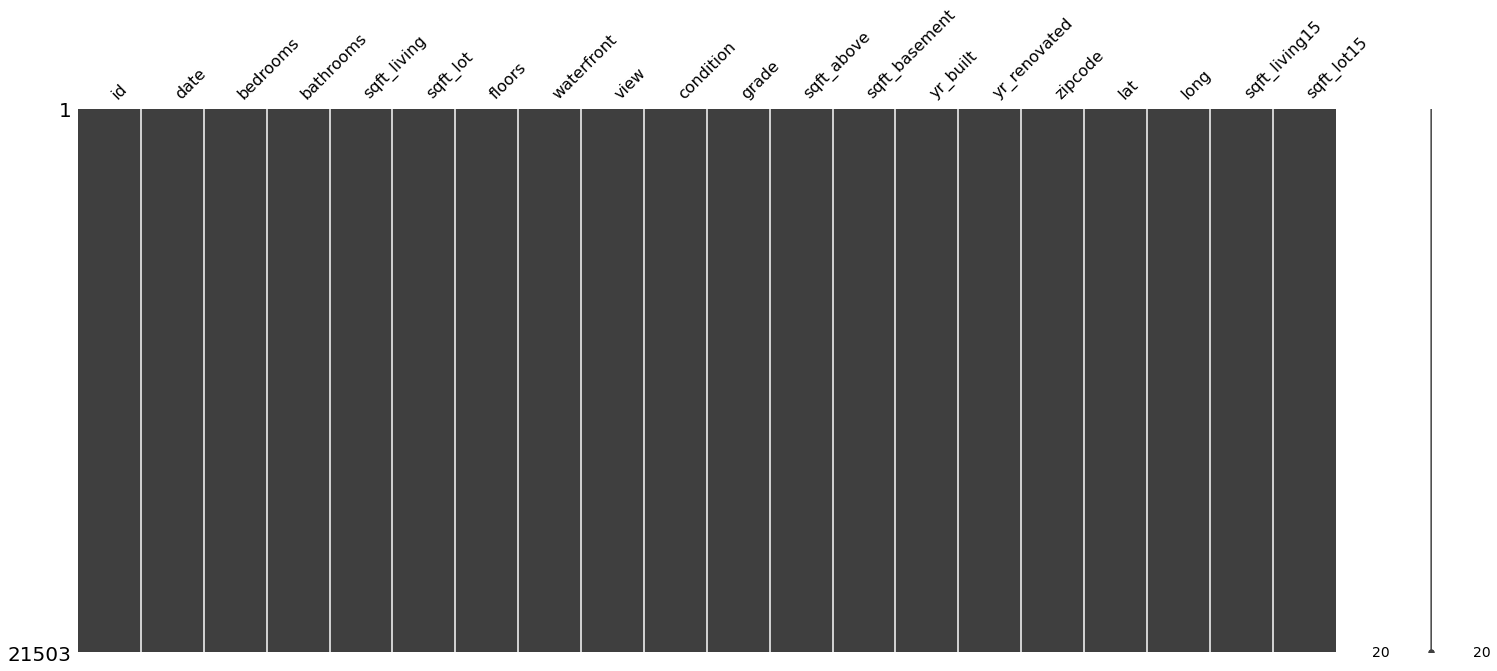

In [48]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [49]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [50]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

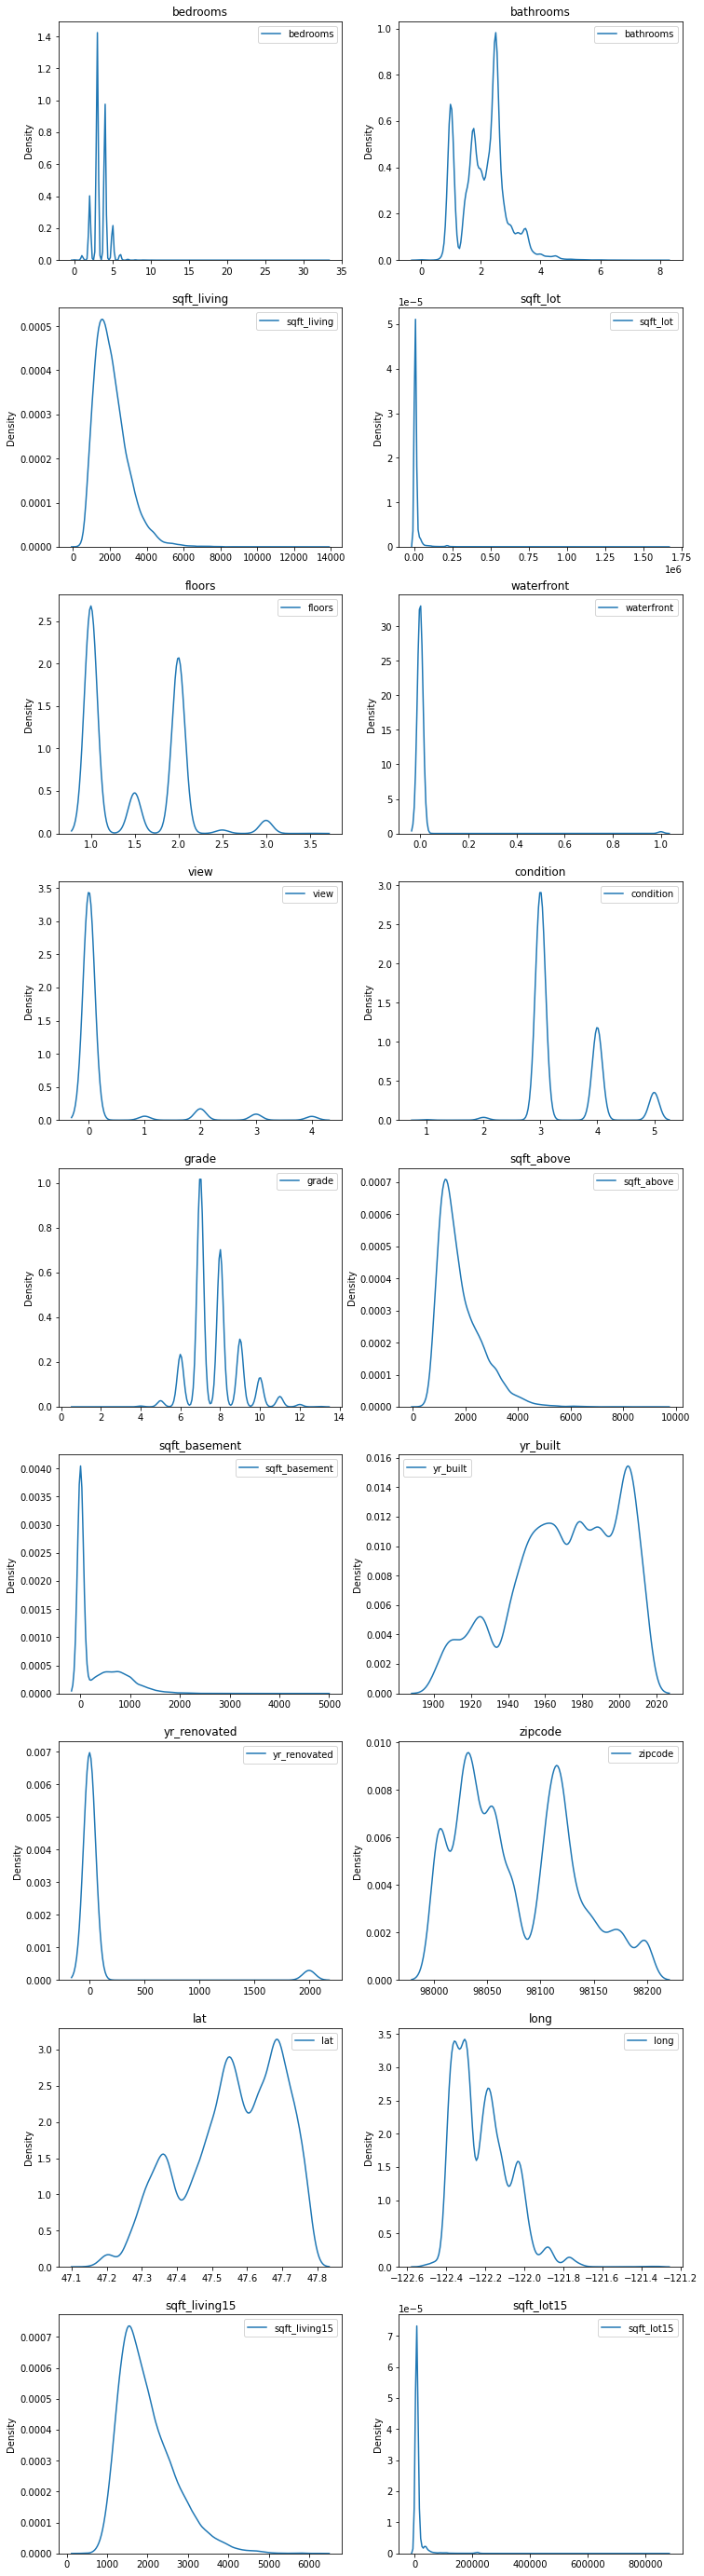

In [51]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))
for i, column in enumerate(data.columns):
    if i:
        sns.kdeplot(data=data[[column]], ax=ax[((i-1)//2)][((i-1)%2)])
        ax[((i-1)//2)][((i-1)%2)].set_title(column)

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [52]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

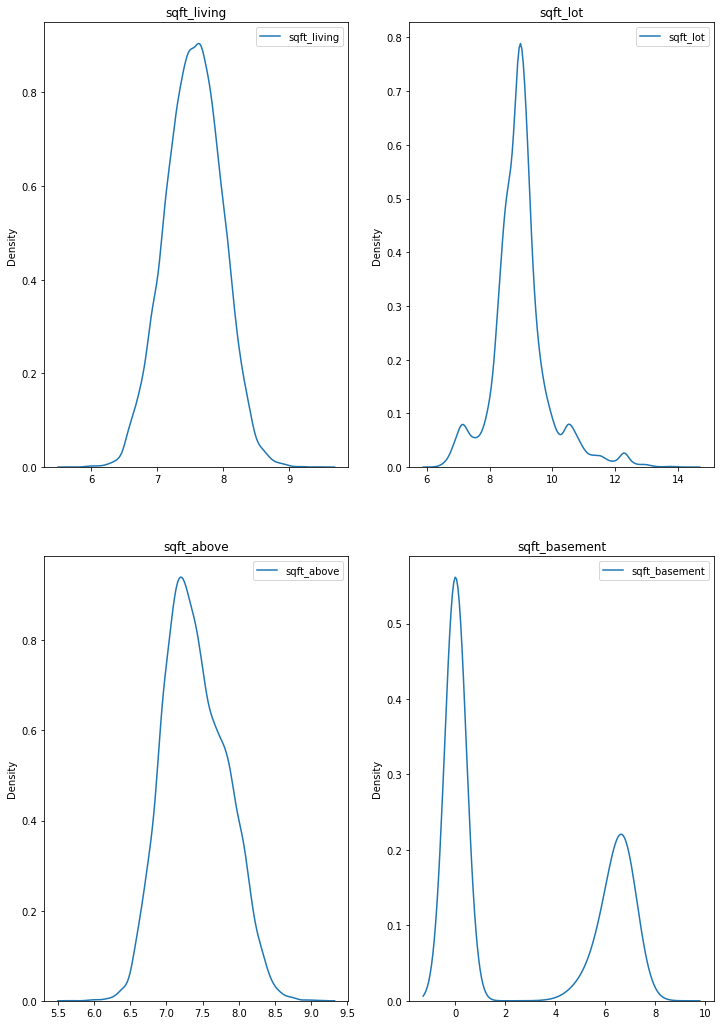

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(12, 18))
for i, column in enumerate(skew_columns):
    if i:
        sns.kdeplot(data=data[[column]], ax=ax[((i-1)//2)][((i-1)%2)])
        ax[((i-1)//2)][((i-1)%2)].set_title(column)

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

### 데이터 분리하기

In [54]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

### 하이퍼 파라미터 세팅

In [55]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [56]:
#그리드 서치
param_gboost = {
    'n_estimators' : range(5, 200, 10),
    'max_features' : range(16, 18),
    'max_depth': range(3, 10),
    'learning_rate' : np.linspace(0.01, 0.1, 5)
}

param_xgboost = {
    'nthread':[4], 
    'objective':['reg:linear'],
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'max_depth': [5, 6, 7],
    'min_child_weight': [4],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators': range(10, 200, 10),
    'lambda' :  np.linspace(0.01, 1, 5),
    'alpha' :  np.linspace(0.01, 1, 5),         
}

param_lightgbm = {
    'n_estimators' : range(5, 50, 10),
    'max_depth': range(3, 10),
    'learning_rate' : np.linspace(0.01, 0.1, 5)
    
}

param_rdforest = {
    'n_estimators' : range(5, 200, 10),
    'max_features' : [18],
    'max_depth': range(3, 15),
}

def grid_search(model_name, X_train, y_train):
    """search best parameters"""
    print(param_rdforest)
    param = {}
    if model_name == "gboost":
        param = param_gboost
        model = GradientBoostingRegressor(random_state=random_state)
    elif model_name == "xgboost":
        param = param_xgboost
        model = xgb.XGBRegressor(random_state=random_state)
    elif model_name == "lightgbm":
        param = param_lightgbm
        model = LGBMRegressor(random_state=random_state)
    elif model_name == "rdforest":
        parma = param_rdforest
        model = RandomForestRegressor(random_state=random_state)
  
    gs = GridSearchCV(estimator=model, 
                      param_grid=param_rdforest, 
                      scoring='neg_mean_squared_error', 
                     cv=5, verbose=2, n_jobs=-1)
    gs.fit(X_train, y_train)
    return gs.best_params_


In [58]:
                                            ##referance ##
#https://www.kaggle.com/code/sungdoo/59th-solution-gb-xgb-lgb-and-overfitdef set_params(model, random_state):
def set_params(model, random_state):    
    if model == "GradientBoosting":
        gboost = GradientBoostingRegressor(n_estimators=15000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =25)
        return gboost
    
    elif model == "XGBoost":
        xgboost = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.0468, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.7817, n_estimators=15000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.8, silent=1,
                             random_state =25, nthread = -1)
        return xgboost
    
    elif model == "LightGBM":
        lightgbm = lgb.LGBMRegressor(objective='regression',num_leave=2,
                              learning_rate=0.05, n_estimators=15000,
                              max_bin = 80, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
        
        return lightgbm
    
    elif model == "rdforest":
        rdforest = RandomForestRegressor(n_estimators = 155,
                                           max_features = 18, 
                                           max_depth = 14, 
                                           random_state=random_state)
        return rdforest

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [70]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m["model"] = set_params(m["name"], 2020)
        m['model'].fit(x.values, y)
        print("{} rmse : {}".format(m["name"], mean_squared_error(y, m['model'].predict(x.values))**0.5))
        
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [71]:
y_pred = AveragingBlending(models, x, y, sub)

GradientBoosting rmse : 49203.61377385258
[12:24:14] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost rmse : 386.89284525362547
LightGBM rmse : 4165.459034719382


### Make Submission

In [72]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [73]:
sub.to_csv('submission.csv', index=False)

In [74]:
y_pred

array([ 561686.20405774,  493008.0689583 , 1266424.46767215, ...,
        500291.16492169,  331455.4543829 ,  442707.61471918])